# Field line image generation

We have data describing what magnetic field lines in 3D space look like when they're projected onto our Phantom camera's sensor. This data is in the form of a bunch of decimal pixel pairs. We need to create a real image of a field line using this representation, and it must have constant intensity along its length.

In [7]:
from scipy.io.idl import readsav
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
import time

## Calculate field line trajectories and plot an example in Z, Phi space 

No port forwarding to alcdata specified. Assuming you are on the PSFC network.


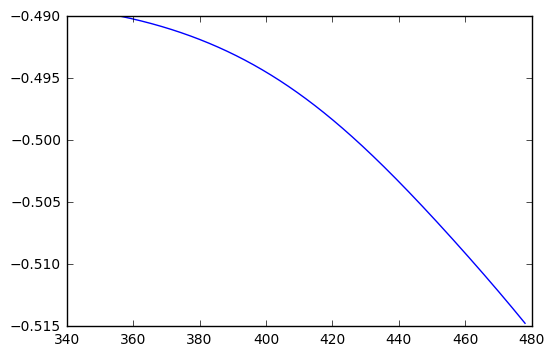

In [46]:
from phantom_viewer import fl_trace

fls = fl_trace.make_fls(1150611004, .780)

plt.figure()
plt.plot(fls[2][0] * 180. / np.pi, fls[1][0])
plt.show()

## [IDL takes trajectories and projects them onto pixel space]

## Read field line trajectories in pixel space and make example pixel pair array

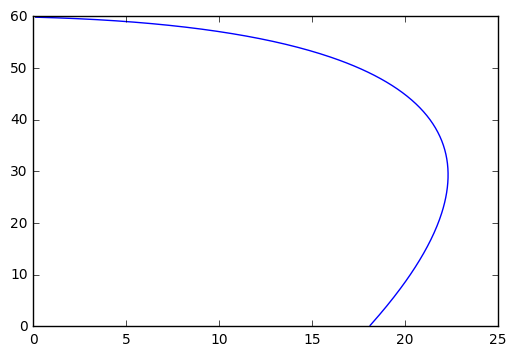

In [170]:
fls = readsav('../fl_images_of_Xpt_fieldlines_1150611004_780ms.sav')
i = 420
xpix = fls.fl_map.xpixfl[i]
ypix = fls.fl_map.ypixfl[i]
pxpairs = zip(xpix, ypix)
pxpairs = [(p[1], p[0]) for p in pxpairs
           if (0 < p[0] < 63) and (0 < p[1] < 63)]

plt.figure()
plt.plot(*zip(*pxpairs))
plt.show()

## Option 1: naively convert from pixel space to image array

Produces field lines of irregular intensity.

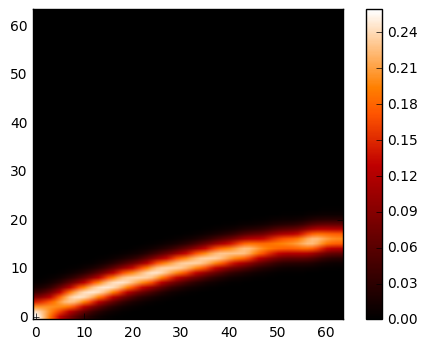

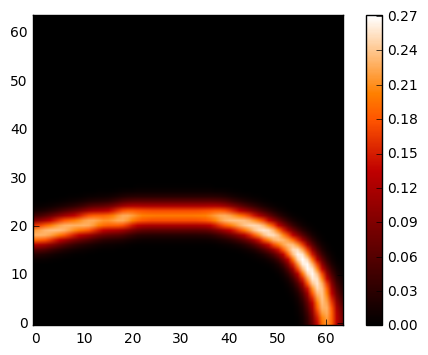

In [111]:
plt.figure()
for i in [200, 420]: 
    xpix = fls.fl_map.xpixfl[i]
    ypix = fls.fl_map.ypixfl[i]
    pxpairs = zip(xpix, ypix)
    pxpairs = [(int(round(p[1])), int(round(p[0]))) for p in pxpairs
               if (0 < p[0] < 63) and (0 < p[1] < 63)]

    image = np.zeros((64, 64))
    image[zip(*pxpairs)] = 1

    image = gaussian_filter(image, 2)

    plt.imshow(image, cmap=plt.cm.gist_heat, origin='bottom')
    plt.colorbar()
    plt.show()

## Option 2: make big image and scale down with smoothing

Field lines still look irregular, even when downscaling includes smoothing. Need to draw thicker lines at the beginning.

### Interpolate pixel-space lines, convert to large image array

Interpolation between pixel pairs appears to be unnecessary.

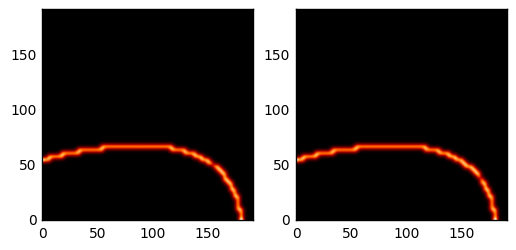

In [10]:
from scipy.interpolate import CubicSpline

pxpairs_scaled = [(3 * int(round(p[0])), 3 * int(round(p[1]))) for p in pxpairs]
image = np.zeros((3 * 64, 3 * 64))
image[zip(*pxpairs_scaled)] = 1

coarse = np.linspace(0, 1, len(xpix))
fine = np.linspace(0, 1, 3 * len(xpix))
xpixi = CubicSpline(coarse, xpix)(fine)
ypixi = CubicSpline(coarse, ypix)(fine)
pxpairsi = zip(xpixi, ypixi)
pxpairsi = [(3 * int(round(p[1])), 3 * int(round(p[0]))) for p in pxpairsi
            if (0 < p[0] < 63) and (0 < p[1] < 63)]
imagei = np.zeros((3 * 64, 3 * 64))
imagei[zip(*pxpairsi)] = 1

image = gaussian_filter(image, 2)
imagei = gaussian_filter(imagei, 2)

plt.figure()
plt.subplot(121)
plt.imshow(image, cmap=plt.cm.gist_heat, origin='bottom')
plt.subplot(122)
plt.imshow(imagei, cmap=plt.cm.gist_heat, origin='bottom')
plt.show()

### Shrink large image using 2D interpolation

Only seems to work for scaling up, scaling down produces weird results.

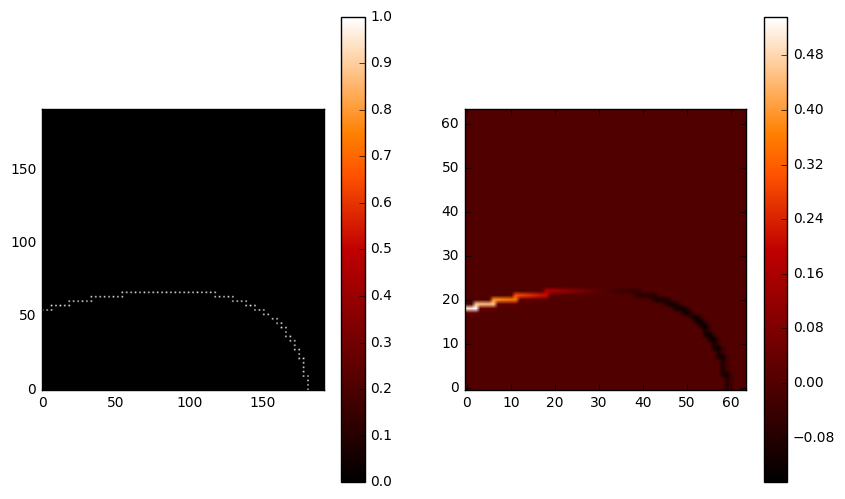

In [99]:
from scipy.interpolate import interp2d

image = np.zeros((3 * 64, 3 * 64))
image[zip(*pxpairs_scaled)] = 1
#image = gaussian_filter(image,2)
x = np.linspace(0, 1, 3 * 64)
y = np.linspace(0, 1, 3 * 64)
xnew = np.linspace(0, 1, 64)
ynew = np.linspace(0, 1, 64)

imsmall = interp2d(x, y, image, kind='cubic')(xnew, ynew)

plt.figure(figsize=(10, 6))
plt.subplot(121)
plt.imshow(image, cmap=plt.cm.gist_heat, origin='bottom')
plt.colorbar()
plt.subplot(122)
plt.imshow(imsmall, cmap=plt.cm.gist_heat, origin='bottom')
plt.colorbar()
plt.show()

## Option 3: plot with matplotlib and save image

Looks smooth outside iPython but side dimension is 71 instead of 64... In iPython, side dimension is correct but it's not smooth and it looks like there's still some unwanted padding. Too hacky.

(64, 64, 3)


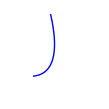

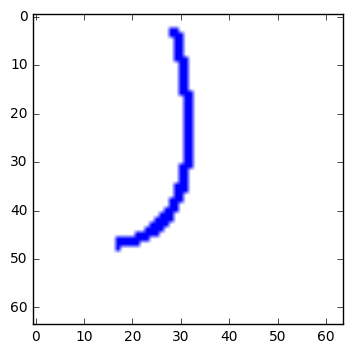

In [47]:
# Make a random plot...
fig = plt.figure(figsize=(64 / 72., 64 / 72.))
fig.add_subplot(111)
plt.plot(*zip(*pxpairs))
plt.xlim([0, 63])
plt.ylim([0, 63])
plt.axis('off')
fig.tight_layout(pad=0)

# If we haven't already shown or saved the plot, then we need to
# draw the figure first...
fig.canvas.draw()
#plt.savefig('asdf.png')

# Now we can save it to a numpy array.
data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
data = data.reshape(fig.canvas.get_width_height()[::-1] + (3, ))

print data.shape

plt.figure()
plt.imshow(data)
plt.show()

## Option 4: manually implemented smoothing

Looks OK but still prone to greater intensity in regions of strong curvature.

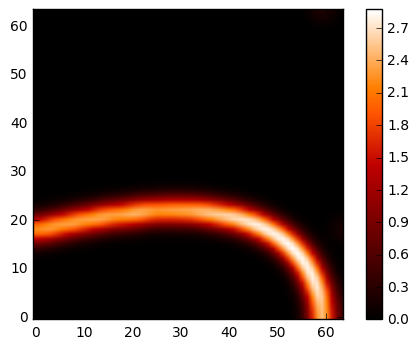

In [171]:
image = np.zeros((64, 64))
for px in pxpairs:
    x = int(px[0])
    y = int(px[1])
    dx = px[0] - x
    dy = px[1] - y
    # Nonsense algorithm created through trial and error
    image[x, y] += np.sqrt(2**2 - dx**2 - dy**2)
    image[x + 1, y] += dx
    image[x - 1, y] += np.sqrt(1 - dx**2)
    image[x, y + 1] += dy
    image[x, y - 1] += np.sqrt(1 - dy**2)
    
for i in range(64):
    for j in range(64):
        image[i, j] = np.min([image[i, j], 7])

image = gaussian_filter(image, 2)

plt.figure()
plt.imshow(image, cmap=plt.cm.gist_heat, origin='bottom')
plt.colorbar()
plt.show()

## Option 5: draw line using PIL on big array, downscale with anti-aliasing

Intensity along the line looks very regular except when there are problems at the edge, which we can fix by drawing and blurring with margins and cropping them at the end.

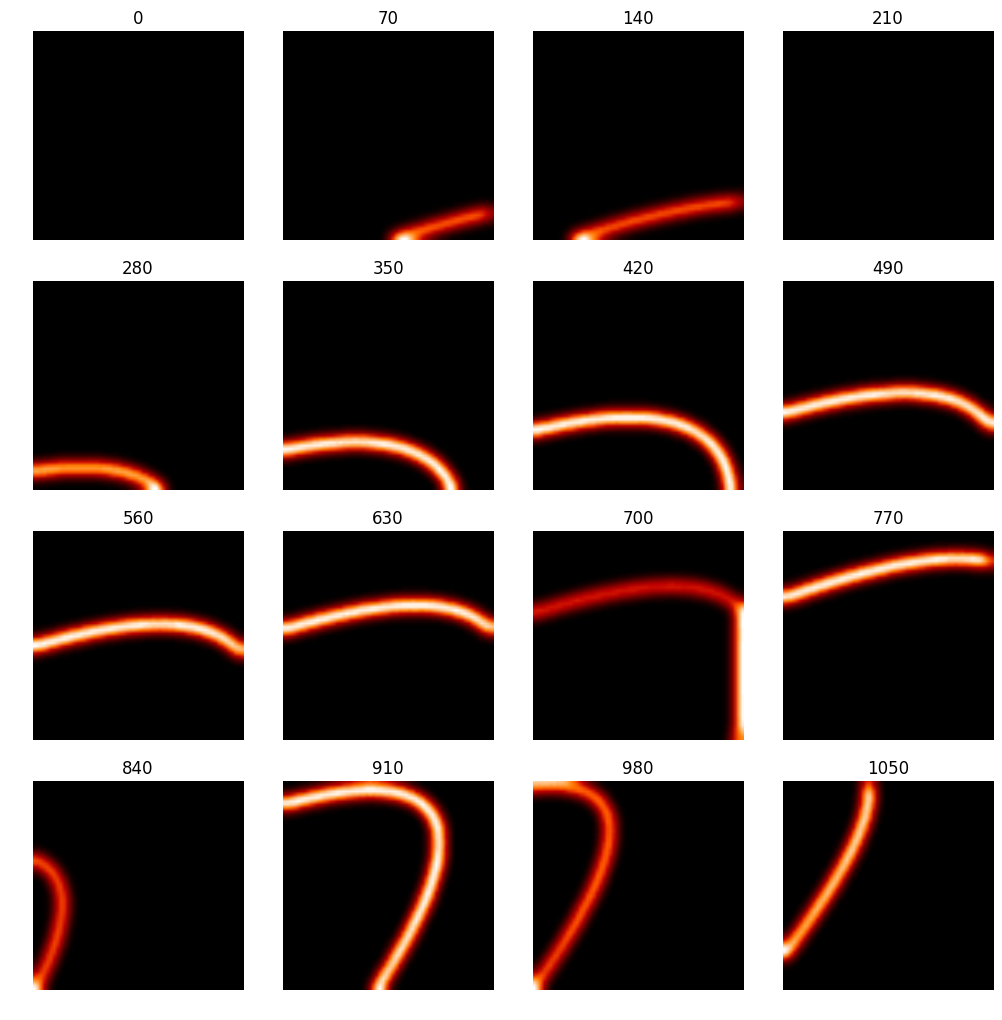

In [112]:
from PIL import Image, ImageDraw
from scipy.ndimage import uniform_filter 

scale_factor = 3
image_indices = range(len(fls.fl_map.xpixfl))[::70]
side = int(np.sqrt(len(image_indices)-1)) + 1

plt.figure(figsize=(10,10))

for ii, i in enumerate(image_indices):
    xpix = fls.fl_map.xpixfl[i]
    ypix = fls.fl_map.ypixfl[i]
    pxpairs = zip(xpix, ypix)
    pxpairs = [(scale_factor * p[1], scale_factor * (p[0]))
               for p in pxpairs if (0 < p[0] < 63) and (0 < p[1] < 63)]

    im = Image.new('L', (scale_factor * 64, scale_factor * 64))

    draw = ImageDraw.Draw(im)
    draw.line(pxpairs, fill=128, width=4)
    del draw

    im = im.resize((64, 64), Image.LANCZOS)
    image = np.asarray(im, dtype=np.uint8)
    image = gaussian_filter(image, 2)
    plt.subplot(side, side, ii+1)
    plt.title(i)
    plt.imshow(np.transpose(image), cmap=plt.cm.gist_heat, origin='bottom')
    plt.axis('off')
    #plt.colorbar()

plt.tight_layout(pad=0)
plt.show()

### Create big image and crop after blurring to fix edge problems

Looks perfect now.

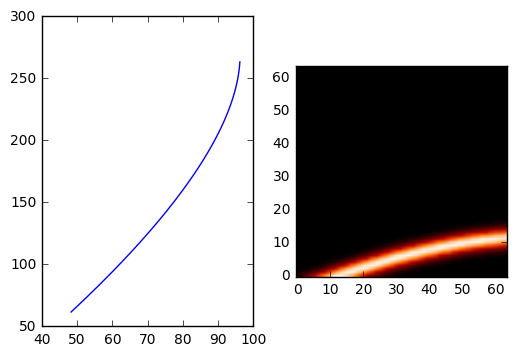

In [168]:
i = 140
end_side = 64
margin = 20

xpix = fls.fl_map.xpixfl[i]
ypix = fls.fl_map.ypixfl[i]
pxpairs = zip(xpix, ypix)
pxpairs = [(scale_factor * (p[1] + margin), scale_factor * (p[0] + margin))
           for p in pxpairs if not p[0] == p[1] == 0] #if (0 < p[0] < 63) and (0 < p[1] < 63)]

im = Image.new('L', (scale_factor * (end_side+2*margin), scale_factor * (end_side+2*margin)))

draw = ImageDraw.Draw(im)
draw.line(pxpairs, fill=128, width=4)
del draw

im = im.resize((end_side + 2*margin, end_side + 2*margin), Image.LANCZOS)
image = np.asarray(im, dtype=np.uint8)
image = gaussian_filter(image, 2)
image = image[margin:-margin, margin:-margin]

plt.figure()
plt.subplot(121)
plt.plot(*zip(*pxpairs))
plt.subplot(122)
plt.imshow(np.transpose(image), cmap=plt.cm.gist_heat, origin='bottom')
plt.show()

### Looked at some other blurring methods

Gaussian filter is probably the better choice because everything looks smoother.

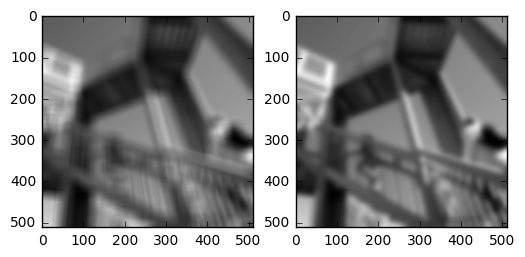

In [137]:
import cv2
import matplotlib.pyplot as plt
from scipy.misc import ascent
from scipy.ndimage.filters import gaussian_filter

img = ascent()
blur = cv2.blur(img,(30,30))
gauss = gaussian_filter(img, 7)

plt.figure()
plt.subplot(121)
plt.imshow(blur, cmap=plt.cm.gray)
plt.subplot(122)
plt.imshow(gauss, cmap=plt.cm.gray)
plt.show()

## Option 6: draw image with Cairo

Looks like PIL does what I need, so I abandoned this option.

In [4]:
import math
import cairocffi as cairo
import io
from IPython.display import Image, display

def surface_to_image(surface):
    buf = io.BytesIO()
    surface.write_to_png(buf)
    data = buf.getvalue()
    buf.close()
    return Image(data=data)

WIDTH, HEIGHT = 64, 64

surface = cairo.ImageSurface (cairo.FORMAT_ARGB32, WIDTH, HEIGHT)
ctx = cairo.Context (surface)

ctx.scale (WIDTH, HEIGHT) # Normalizing the canvas
ctx.rectangle (0, 0, 1, 1) # Rectangle(x0, y0, x1, y1)
ctx.fill ()

ctx.translate (0.1, 0.1) # Changing the current transformation matrix

ctx.move_to (0, 0)
#ctx.arc (0.2, 0.1, 0.1, -math.pi/2, 0) # Arc(cx, cy, radius, start_angle, stop_angle)
ctx.line_to (0.5, 0.1) # Line to (x,y)
#ctx.curve_to (0.5, 0.2, 0.5, 0.4, 0.2, 0.8) # Curve(x1, y1, x2, y2, x3, y3)
#ctx.close_path ()

ctx.set_source_rgb (1,1, 1) # Solid color
ctx.set_line_width (0.02)
ctx.stroke ()

#surface.write_to_png ("example.png") # Output to PNG
image = surface_to_image(surface)